In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely as sp
import random
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.cm as cm

Get Bounds of Initial Dataset

In [2]:
data_folder = Path("data/roadimages")
no_roads_folder = "1 _ No Roads"

file_paths = [file_path for file_path in data_folder.rglob("*") if file_path.is_file() and no_roads_folder not in file_path.parts]

file_names = [file_path.stem for file_path in data_folder.rglob("*") if file_path.is_file() and no_roads_folder not in file_path.parts]

file_parts = [file_name.split("_") for file_name in file_names]

sorted_file_parts = sorted(file_parts, key=lambda x: float(x[-1]))

min_lon = float(sorted_file_parts[0][-1])
max_lon = float(sorted_file_parts[-1][-1])
sorted_file_parts

sorted_file_parts = sorted(file_parts, key=lambda x: float(x[-2]))
min_lat = float(sorted_file_parts[0][-2])
max_lat = float(sorted_file_parts[-1][-2])
#sorted_file_parts


print("Minimum latitude:", min_lat)
print("Maximum latitude:", max_lat)

print("Minimum longitude:", min_lon)
print("Maximum longitude:", max_lon)

Minimum latitude: 14.501167
Maximum latitude: 14.69918
Minimum longitude: 120.963593
Maximum longitude: 121.105042


In [3]:
shape = gpd.read_file("data/shapefiles/gis_osm_roads_free_1.shp")
dataset_area = gpd.read_file("data/shapefiles/dataset_area.shp")

dataset_area

,geometry
0,"POLYGON ((120.93428 14.47773, 121.1335 14.4739..."


In [4]:
dataset_roads = shape[dataset_area['geometry'].item().contains(shape['geometry'])]

dataset_roads.count()

osm_id      142331
code        142331
fclass      142331
name         59119
ref           5241
oneway      142331
maxspeed    142331
layer       142331
bridge      142331
tunnel      142331
geometry    142331
dtype: int64

In [5]:
dataset_roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,267,5152,cycleway,Maharlika Street,None,B,25,0,F,F,"LINESTRING (121.05212 14.6503, 121.05223 14.65..."
2,2667097,5113,primary,Taft Avenue,170,F,60,0,F,F,"LINESTRING (120.99671 14.55627, 120.9967 14.55..."
3,2667099,5113,primary,Lerma Street,170,F,50,0,F,F,"LINESTRING (120.98539 14.6046, 120.98545 14.60..."
4,2667105,5122,residential,E. Manaloto Street,None,B,0,0,F,F,"LINESTRING (120.9938 14.54125, 120.99497 14.54..."
5,2667111,5113,primary,Quezon Boulevard,170,F,60,0,F,F,"LINESTRING (120.98018 14.59292, 120.98002 14.5..."


<Axes: >

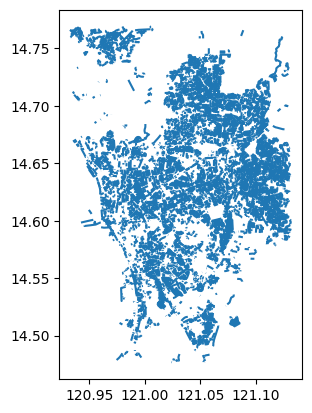

In [6]:
dataset_roads[:10000].plot()

In [7]:
dataset_roads['fclass'].unique()

array(['cycleway', 'primary', 'residential', 'secondary', 'tertiary',
       'motorway', 'trunk', 'primary_link', 'trunk_link', 'service',
       'unclassified', 'footway', 'steps', 'pedestrian', 'secondary_link',
       'motorway_link', 'tertiary_link', 'track', 'path', 'busway',
       'track_grade4', 'living_street', 'bridleway', 'track_grade5',
       'track_grade1'], dtype=object)

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
711,4483587,5122,residential,Zodiac Street,None,B,0,0,F,F,"LINESTRING (121.03515 14.55605, 121.03552 14.5..."
1370,4940456,5122,residential,Recoletos Street,None,B,0,0,F,F,"LINESTRING (121.03432 14.55529, 121.03434 14.5..."
5901,14712757,5113,primary,Kalayaan Overpass,191,F,60,1,T,F,"LINESTRING (121.03568 14.55571, 121.03538 14.5..."
7659,22882909,5115,tertiary,Jupiter Street,None,B,30,0,F,F,"LINESTRING (121.03501 14.55593, 121.03494 14.5..."
23798,28535210,5115,tertiary,Zodiac Street,None,B,30,0,F,F,"LINESTRING (121.03501 14.55593, 121.03485 14.5..."
23859,28538743,5112,trunk,EDSA,1,F,60,0,F,F,"LINESTRING (121.03549 14.55549, 121.03522 14.5..."
23975,28574025,5132,trunk_link,None,None,F,0,1,T,F,"LINESTRING (121.03487 14.55522, 121.03495 14.5..."
29108,29213181,5112,trunk,EDSA,1,F,60,0,F,F,"LINESTRING (121.03508 14.55511, 121.0349 14.55..."
29110,29213301,5113,primary,Kalayaan Overpass,191,F,60,1,T,F,"LINESTRING (121.03447 14.55542, 121.03459 14.5..."
173565,146300437,5113,primary,Senator Gil J. Puyat Avenue,190,F,40,0,F,F,"LINESTRING (121.03507 14.55532, 121.03501 14.5..."


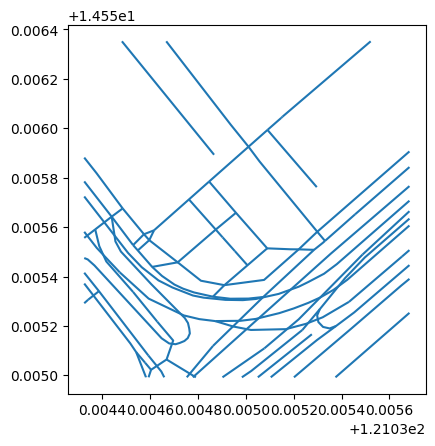

In [8]:
centerx, centery = (121.035004, 14.555672)

offset = 0.00068
minx, miny, maxx, maxy = (centerx - offset, centery - offset, centerx + offset, centery + offset)
bbox = sp.geometry.box(minx, miny, maxx, maxy)

road_patch = dataset_roads.cx[minx:maxx, miny:maxy]
road_patch.loc[:, 'geometry'] = road_patch['geometry'].apply(lambda geom: geom.intersection(bbox))
road_patch = road_patch[~road_patch.is_empty]

road_patch.plot()

road_patch

In [9]:
PATCH_SIZE = 512 # Size of the patches
EARTH_CIRCUFERENCE = 40075016.686 # in meters
SEARCH_INTERVAL = 50  # Distance between interpolated points
SEARCH_RANGE = 10 # pixels the road can be adjusted to find the best fit [coords-SEARCH_RANGE, coords+SEARCH_RANGE]
LINE_LENGTH = 20  # Total length of perpendicular lines
MAX_DISTANCE_FROM_ROAD = 50 # Maximum distance a point can be from a road mask
MAX_ROAD_WIDTH = 150 # Maximum width of a road for it to be considered
LAT_SIZE = 0.0013364 # Estimated degrees per 512 pixels (latitude)
LONG_SIZE = 0.00137216 # Estimated degrees per 512 pixels (longitude)

Display Random Patch

data\roadmasks\155__14.537062_121.052856.png
Random patch path: data\roadimages\3 _ Clear Regular Roads\155__14.537062_121.052856.png


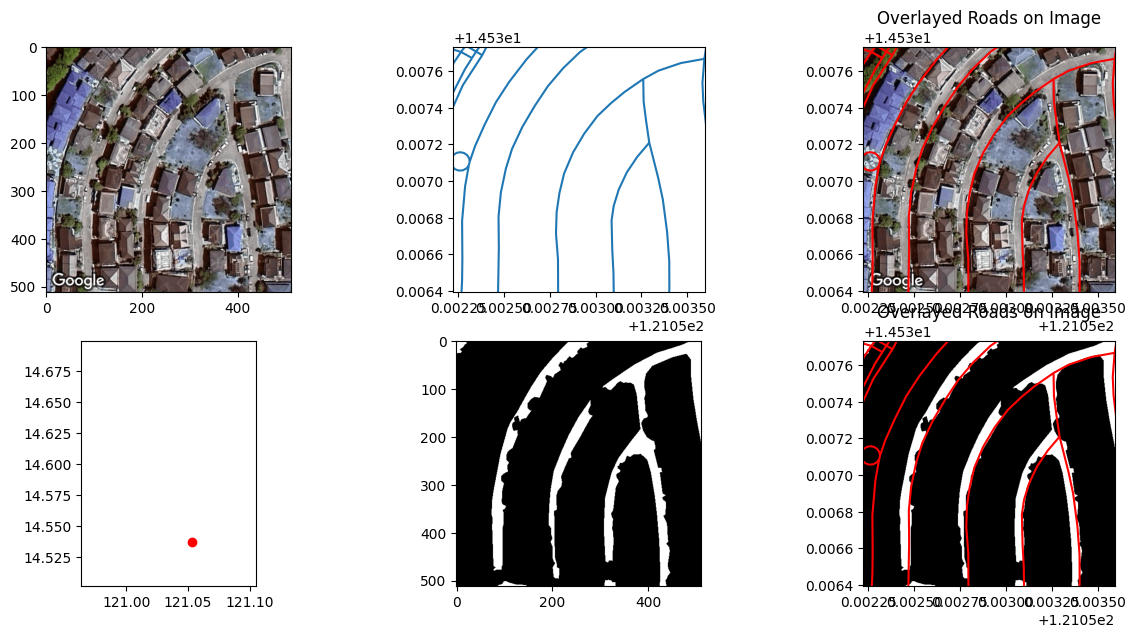

In [203]:
#get file paths
#data\roadimages\3 _ Clear Regular Roads\57__14.557001_121.006165.png
DISPLAY_ALLOWANCE = 0.0000

random_patch_path = random.choice(file_paths)
folder_names = ["\\1 _ No Roads", "\\2 _ Roads with Occlusions", "\\3 _ Clear Regular Roads", "\\4 _ Wide Roads"]
mask_path = str(random_patch_path).replace("roadimages", "roadmasks")

#remove folder names from mask paths
for folder_name in folder_names:
    mask_path = mask_path.replace(folder_name, "")
print(mask_path)

#set patch size
lat_size = LAT_SIZE/2
long_size = LONG_SIZE/2
#right = increase lon offset; up = increase lat offset
lat_shift = 0.0000
lon_shift = -0.000053
random_patch_lat = float(random_patch_path.stem.split("_")[-2])
random_patch_lon = float(random_patch_path.stem.split("_")[-1])

#adjust linestring coordinates 
minx, miny, maxx, maxy = (random_patch_lon - long_size, random_patch_lat - lat_size, random_patch_lon + long_size, random_patch_lat + lat_size)
minx = minx - lon_shift
maxx = maxx - lon_shift
miny = miny - lat_shift
maxy = maxy - lat_shift
bbox = sp.geometry.box(minx, miny, maxx, maxy)

#remove roads outside of patch
random_patch_roads = dataset_roads.cx[minx:maxx, miny:maxy]

print("Random patch path:", random_patch_path)

image = cv2.imread(str(random_patch_path))
mask_image = cv2.imread(str(mask_path))

if random_patch_roads.empty:
    print("No roads found in the random patch.")
    plt.imshow(image)
else:

    #show road patch
    fig, axes = plt.subplots(2, 3, figsize=(15, 7))
    axes[0][0].imshow(image)

    #plot linestrings (roadlines)
    random_patch_roads.plot(ax=axes[0][1])

    axes[0][1].set_xlim(minx-DISPLAY_ALLOWANCE, maxx+DISPLAY_ALLOWANCE)
    axes[0][1].set_ylim(miny-DISPLAY_ALLOWANCE, maxy+DISPLAY_ALLOWANCE)
    axes[0][1].set_aspect('equal')

    #overlay linestrings on patch
    axes[0][2].imshow(image, extent=[minx, maxx, miny, maxy])
    random_patch_roads.plot(ax=axes[0][2], color='red')
    axes[0][2].set_title("Overlayed Roads on Image")
    axes[0][2].set_xlim(minx-DISPLAY_ALLOWANCE, maxx+DISPLAY_ALLOWANCE)
    axes[0][2].set_ylim(miny-DISPLAY_ALLOWANCE, maxy+DISPLAY_ALLOWANCE)
    axes[0][2].set_aspect('equal')

    #coordinates relative to total dataset area
    axes[1][0].scatter(random_patch_lon, random_patch_lat, color='red')
    axes[1][0].set_xlim(min_lon, max_lon)
    axes[1][0].set_ylim(min_lat, max_lat)
    axes[1][0].set_aspect('equal')
    
    #ground truth mask
    axes[1][1].imshow(mask_image)

    #overlay linestrings on ground truth mask
    axes[1][2].imshow(mask_image, extent=[minx, maxx, miny, maxy])
    random_patch_roads.plot(ax=axes[1][2], color='red')
    axes[1][2].set_title("Overlayed Roads on Image")
    axes[1][2].set_xlim(minx, maxx)
    axes[1][2].set_ylim(miny, maxy)
    axes[1][2].set_aspect('equal')

    plt.show()


In [204]:
random_patch_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
56833,48387351,5122,residential,Pinetree,None,B,0,0,F,F,"LINESTRING (121.05367 14.5359, 121.05371 14.53..."
56834,48387353,5122,residential,McKinley Hill Drive,None,B,0,0,F,F,"LINESTRING (121.05368 14.53799, 121.05353 14.5..."
56835,48387355,5122,residential,Highland,None,B,0,0,F,F,"LINESTRING (121.0528 14.53632, 121.0528 14.536..."
56836,48387356,5122,residential,Hillside,None,B,0,0,F,F,"LINESTRING (121.0531 14.53629, 121.0531 14.536..."
56837,48387357,5122,residential,Princeton,None,B,0,0,F,F,"LINESTRING (121.05339 14.53626, 121.0534 14.53..."
57776,48786590,5114,secondary,Upper McKinley Road,None,F,50,0,F,F,"LINESTRING (121.05402 14.5395, 121.05394 14.53..."
294142,235963352,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05223 14.53772, 121.05222 14.5..."
294143,235963353,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05212 14.53771, 121.05216 14.5..."
437336,366906388,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05231 14.53711, 121.05231 14.5..."
437337,366906389,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.05231 14.53711, 121.05234 14.5..."


In [205]:
#create scaled version of cropped linemap to fit mask
# Calculate scaling factors
# Function to scale geometries
def scale_geometry(geom, x_scale, y_scale):
    return sp.affinity.scale(geom, xfact=x_scale, yfact=y_scale, origin=(0,0))

def shift_geometry(geom, x_shift, y_shift):
    return sp.affinity.translate(geom, xoff=-x_shift, yoff=-y_shift)

# Create a copy of the GeoDataFrame and apply scaling to the copy
scaled_patch_roads = random_patch_roads.copy()

scaled_patch_roads["geometry_scaled"] = scaled_patch_roads["geometry"].apply(
    lambda geom: shift_geometry(geom, minx, miny)
)
scaled_patch_roads["geometry_scaled"] = scaled_patch_roads["geometry_scaled"].apply(
    lambda geom: scale_geometry(geom, 512/(maxx-minx), 512/(maxy-miny))
)

x_shift_initial = minx
y_shift_initial = miny
x_scale = 512/(maxx-minx)
y_scale = 512/(maxy-miny)

scaled_patch_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,geometry_scaled
56833,48387351,5122,residential,Pinetree,None,B,0,0,F,F,"LINESTRING (121.05367 14.5359, 121.05371 14.53...","LINESTRING (541.22388 -190.67824, 556.14925 -6..."
56834,48387353,5122,residential,McKinley Hill Drive,None,B,0,0,F,F,"LINESTRING (121.05368 14.53799, 121.05353 14.5...","LINESTRING (545.40299 612.95181, 489.39552 605..."
56835,48387355,5122,residential,Highland,None,B,0,0,F,F,"LINESTRING (121.0528 14.53632, 121.0528 14.536...","LINESTRING (213.87313 -27.7378, 213.46269 68.3..."
56836,48387356,5122,residential,Hillside,None,B,0,0,F,F,"LINESTRING (121.0531 14.53629, 121.0531 14.536...","LINESTRING (327.41791 -39.61449, 326.41045 39...."
56837,48387357,5122,residential,Princeton,None,B,0,0,F,F,"LINESTRING (121.05339 14.53626, 121.0534 14.53...","LINESTRING (437.00746 -51.29961, 440.14179 6.4..."
57776,48786590,5114,secondary,Upper McKinley Road,None,F,50,0,F,F,"LINESTRING (121.05402 14.5395, 121.05394 14.53...","LINESTRING (669.91791 1189.58396, 640.4403 113..."
294142,235963352,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05223 14.53772, 121.05222 14.5...","LINESTRING (1.44776 506.40647, -2.80597 513.11..."
294143,235963353,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05212 14.53771, 121.05216 14.5...","LINESTRING (-37.35821 505.79348, -23.32836 502..."
437336,366906388,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05231 14.53711, 121.05231 14.5...","LINESTRING (33.79851 272.62736, 32.49254 280.0..."
437337,366906389,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.05231 14.53711, 121.05234 14.5...","LINESTRING (33.79851 272.62736, 44.73134 305.2..."


In [206]:
def get_binary_mask_from_image(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return np.flipud(image_mask)

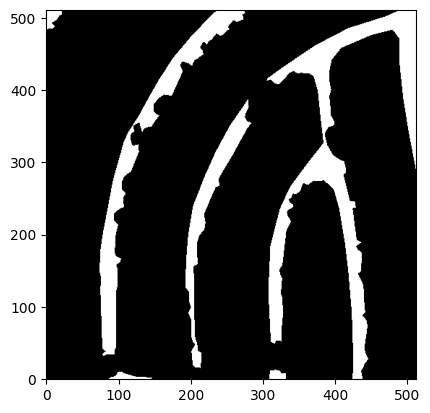

In [207]:
image_mask = get_binary_mask_from_image(mask_image)
plt.imshow(image_mask, cmap='gray')
plt.gca().invert_yaxis()

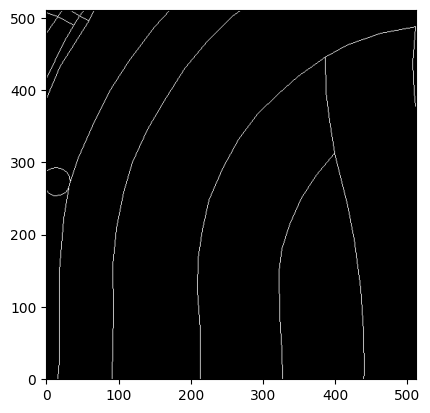

In [208]:
def get_binary_mask_from_roads(scaled_patch_roads):
    road_mask = np.zeros((512, 512), dtype=np.uint8)
    for geom in scaled_patch_roads["geometry_scaled"]:
        if geom.is_empty:
            continue
        if isinstance(geom, sp.LineString):
            coords = np.array(geom.coords, dtype=np.int32)
            cv2.polylines(road_mask, [coords], isClosed=False, color=1, thickness=1)
    return road_mask

road_mask = get_binary_mask_from_roads(scaled_patch_roads)
plt.imshow(road_mask, cmap='gray')
plt.gca().invert_yaxis()


In [209]:
def get_intersection(road_mask, image_mask):
    return np.sum((road_mask > 0) & (image_mask > 0))

In [210]:
shifted_road_masks = [[None for _ in range(2 * SEARCH_RANGE + 1)] for _ in range(2 * SEARCH_RANGE + 1)]

for i in range(-SEARCH_RANGE, SEARCH_RANGE + 1):
    for j in range(-SEARCH_RANGE, SEARCH_RANGE + 1):
        road_copy = scaled_patch_roads.copy()
        road_copy["geometry_scaled"] = road_copy["geometry_scaled"].apply(
            lambda geom: shift_geometry(geom, i, j)
        )
        road_mask = get_binary_mask_from_roads(road_copy)
        shifted_road_masks[i + SEARCH_RANGE][j + SEARCH_RANGE] = road_mask

max_intersection = -1
max_i = -1
max_j = -1

# Iterate through the shifted_road_masks to find the greatest intersection
for i in range(2 * SEARCH_RANGE + 1):
    for j in range(2 * SEARCH_RANGE + 1):
        road_mask = shifted_road_masks[i][j]
        intersection = get_intersection(road_mask, image_mask)
        if intersection > max_intersection:
            max_intersection = intersection
            max_i = i
            max_j = j

best_road_mask = shifted_road_masks[max_i][max_j]

best_shift_values = (max_i - SEARCH_RANGE, max_j - SEARCH_RANGE)


x_shift_second, y_shift_second = best_shift_values[0], best_shift_values[1]

print(f"Maximum intersection: {max_intersection}")
print(f"Shift coordinates: ({max_i - SEARCH_RANGE}, {max_j - SEARCH_RANGE})")

Maximum intersection: 1904
Shift coordinates: (10, -10)


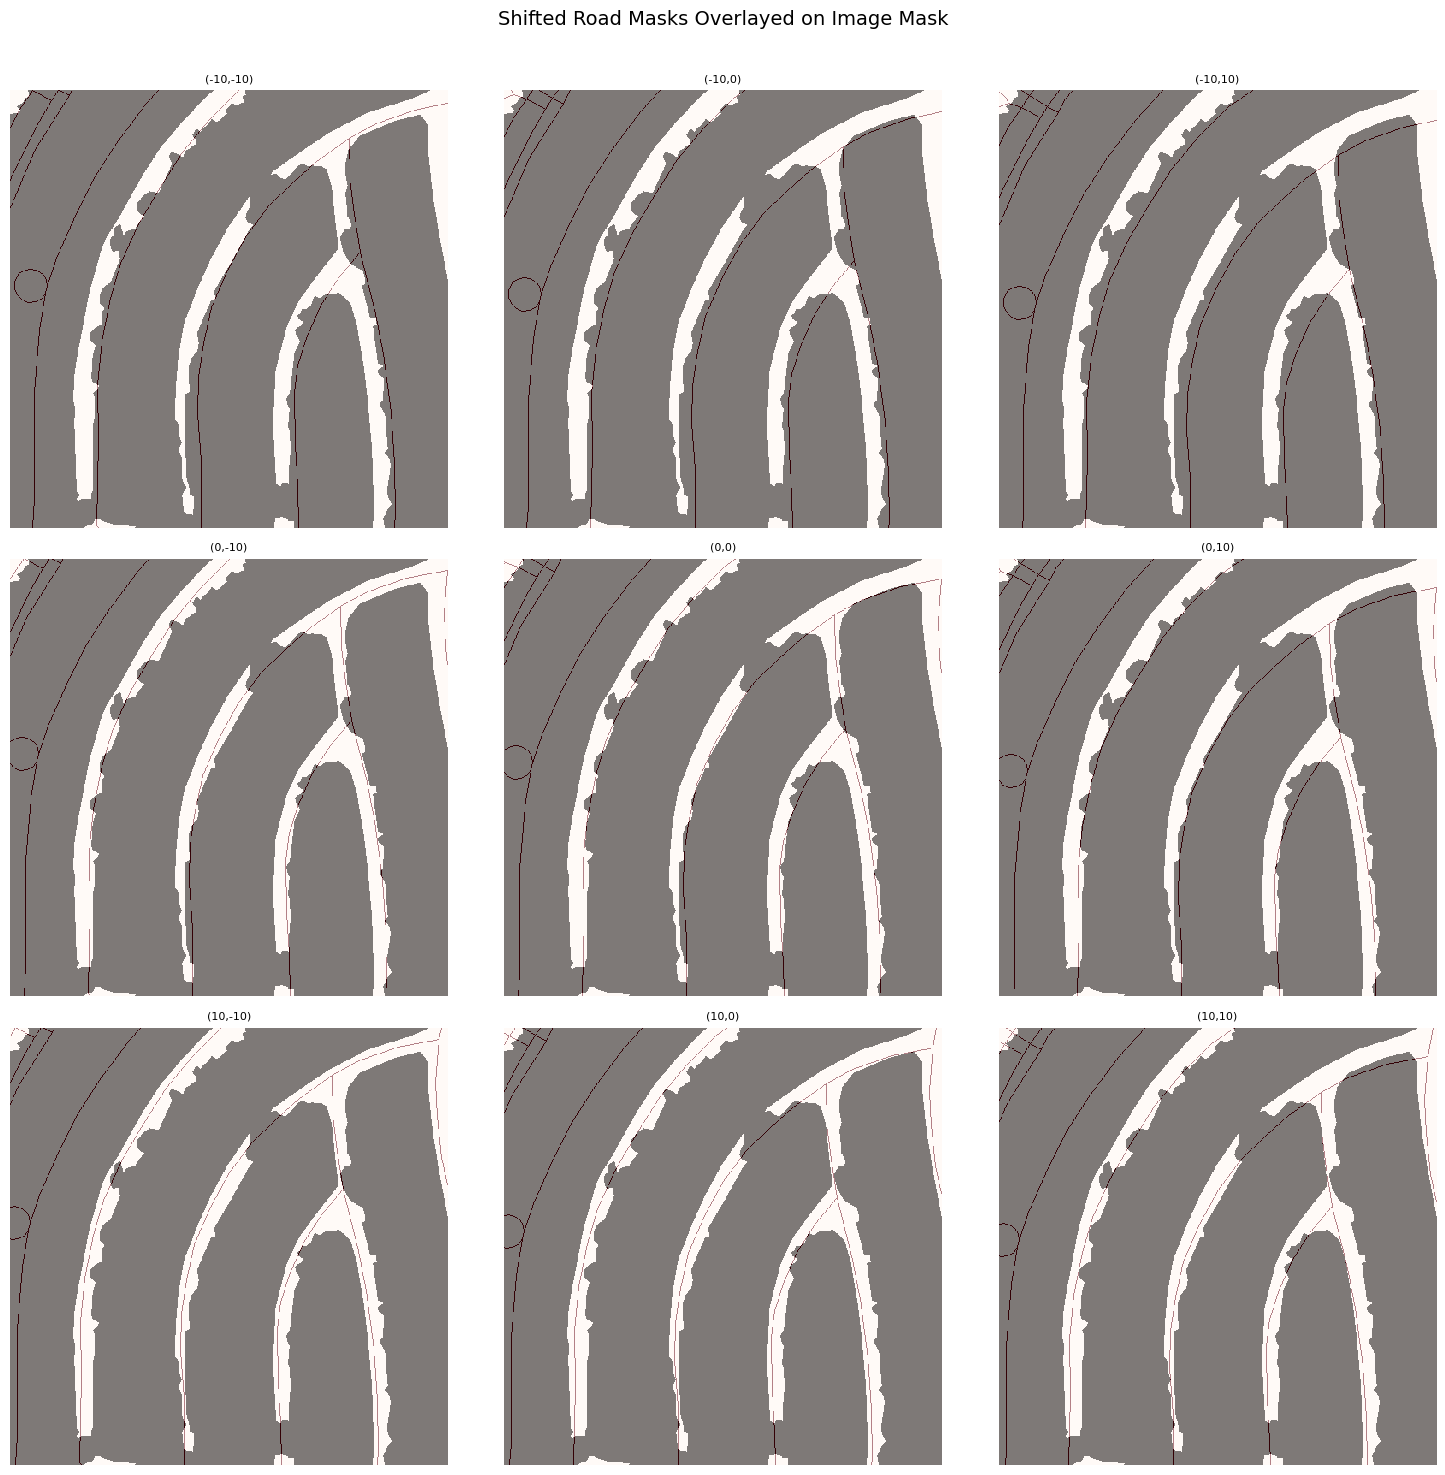

In [211]:
num_display = 3

fig, axes = plt.subplots(num_display, num_display, figsize=(15, 15))
for i in range(num_display):
    for j in range(num_display):
        ax = axes[i, j]
        num = (2 * SEARCH_RANGE)/(num_display-1)
        i_2 = int(i*num)
        j_2 = int(j*num)
        road_mask = shifted_road_masks[i_2][j_2]
        ax.imshow(image_mask, cmap='gray', interpolation='none')
        ax.imshow(road_mask, cmap='Reds', alpha=0.5, interpolation='none')
        ax.set_title(f"({i_2-SEARCH_RANGE},{j_2-SEARCH_RANGE})", fontsize=8)
        ax.axis('off')
        ax.invert_yaxis()
        ax.set_aspect('equal')

plt.suptitle("Shifted Road Masks Overlayed on Image Mask", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

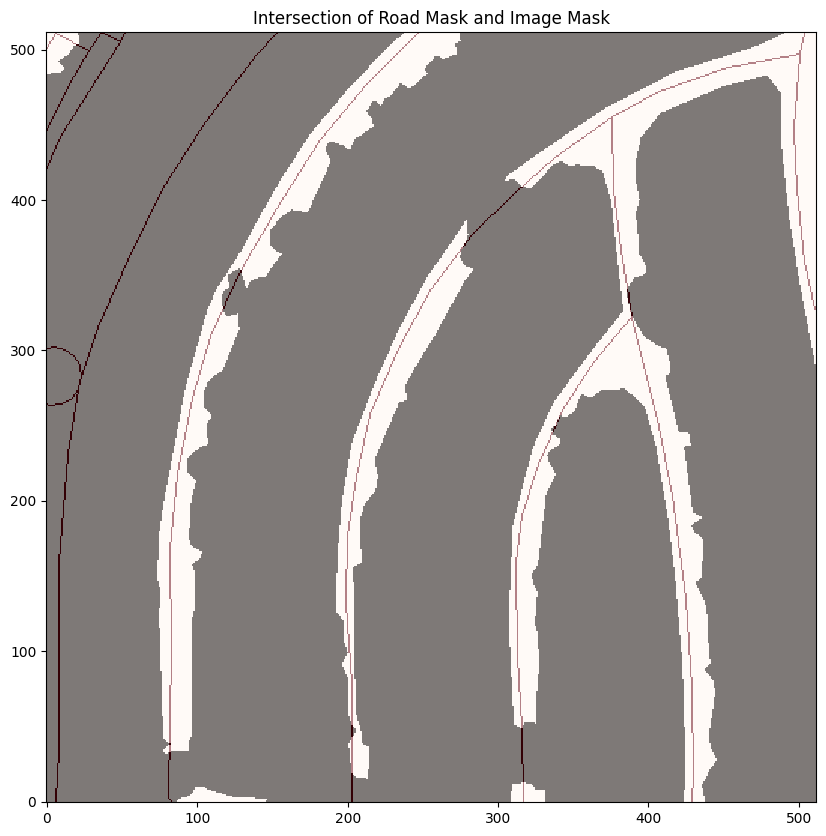

In [212]:
plt.figure(figsize=(10, 10))
plt.imshow(image_mask, cmap='gray', interpolation='none')
plt.imshow(best_road_mask, cmap='Reds', alpha=0.5, interpolation='none')  # Overlay road_mask in red with transparency
plt.title("Intersection of Road Mask and Image Mask")
plt.gca().invert_yaxis()
plt.show()

In [213]:
scaled_patch_roads["geometry_scaled"] = scaled_patch_roads["geometry_scaled"].apply(
    lambda geom: shift_geometry(geom, best_shift_values[0], best_shift_values[1])
)

scaled_patch_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,geometry_scaled
56833,48387351,5122,residential,Pinetree,None,B,0,0,F,F,"LINESTRING (121.05367 14.5359, 121.05371 14.53...","LINESTRING (531.22388 -180.67824, 546.14925 -5..."
56834,48387353,5122,residential,McKinley Hill Drive,None,B,0,0,F,F,"LINESTRING (121.05368 14.53799, 121.05353 14.5...","LINESTRING (535.40299 622.95181, 479.39552 615..."
56835,48387355,5122,residential,Highland,None,B,0,0,F,F,"LINESTRING (121.0528 14.53632, 121.0528 14.536...","LINESTRING (203.87313 -17.7378, 203.46269 78.3..."
56836,48387356,5122,residential,Hillside,None,B,0,0,F,F,"LINESTRING (121.0531 14.53629, 121.0531 14.536...","LINESTRING (317.41791 -29.61449, 316.41045 49...."
56837,48387357,5122,residential,Princeton,None,B,0,0,F,F,"LINESTRING (121.05339 14.53626, 121.0534 14.53...","LINESTRING (427.00746 -41.29961, 430.14179 16...."
57776,48786590,5114,secondary,Upper McKinley Road,None,F,50,0,F,F,"LINESTRING (121.05402 14.5395, 121.05394 14.53...","LINESTRING (659.91791 1199.58396, 630.4403 114..."
294142,235963352,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05223 14.53772, 121.05222 14.5...","LINESTRING (-8.55224 516.40647, -12.80597 523...."
294143,235963353,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05212 14.53771, 121.05216 14.5...","LINESTRING (-47.35821 515.79348, -33.32836 512..."
437336,366906388,5141,service,None,None,F,0,0,F,F,"LINESTRING (121.05231 14.53711, 121.05231 14.5...","LINESTRING (23.79851 282.62736, 22.49254 290.0..."
437337,366906389,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.05231 14.53711, 121.05234 14.5...","LINESTRING (23.79851 282.62736, 34.73134 315.2..."


In [214]:
def interpolate_points(line, distance_interval):
    length = line.length
    num_points = math.ceil(length / distance_interval)
    distances = [i * distance_interval for i in range(num_points + 1)]
    points = [line.interpolate(distance) for distance in distances]
    #remove points that are out of bounds
    points = [point for point in points if point.x >= 0 and point.x < 512 and point.y >= 0 and point.y < 512]
    return points

In [215]:
def perpendicular_line_eq(line, point):
    coords = list(line.coords)

    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        segment = sp.LineString([(x1, y1), (x2, y2)])

        if segment.distance(point) <= 1e-7:  # Check if point is close to the segment
            # Compute original slope
            if x2 - x1 == 0:  # Vertical line
                return (0, point.y)
            elif y2 - y1 == 0:  # Horizontal line
                return (float('inf'), point.x)
            
            slope = (y2 - y1) / (x2 - x1)
            perp_slope = -1 / slope  # Perpendicular slope

            x, y = point.x, point.y
            b = y - perp_slope * x

            return (perp_slope, b)
    
    return None

In [216]:
#gets point slope pairs of a road line
def compute_points_and_perpendiculars(road_line, distance_interval):
    point_slope_pairs = []
    points = interpolate_points(road_line, distance_interval)
    for point in points:
                perp_result = perpendicular_line_eq(road_line, point)
                if perp_result is not None:
                    slope, intercept = perp_result
                    point_slope_pairs.append((point, slope))
    return point_slope_pairs
    

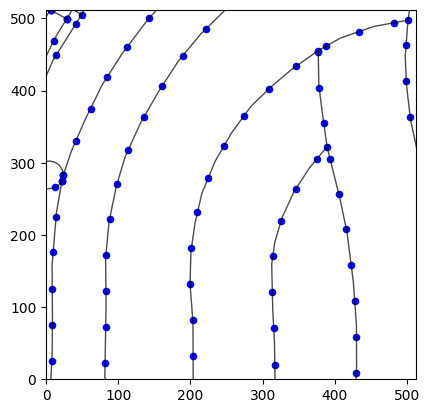

In [217]:
bbox = sp.geometry.box(0, 0, 512, 512)
point_line_eq = []
for road in scaled_patch_roads['geometry_scaled'].items():
    geom = road[1]
    
    if isinstance(geom, sp.MultiLineString):
        for line in geom.geoms:
            # Plot the line being interpolated
            x, y = line.xy
            plt.plot(x, y, color='black', linewidth=1, alpha=0.7)
            point_slope_pairs = compute_points_and_perpendiculars(line, SEARCH_INTERVAL)
            for point_slope_pair in point_slope_pairs:
                point, slope = point_slope_pair
                # if slope == float('inf'):
                #     x1, x2 = point.x, point.x
                #     y1, y2 = point.y - LINE_LENGTH / 2, point.y + LINE_LENGTH / 2
                #     plt.plot([x1, x2], [y1, y2], color='red')
                # else:
                #     dx = LINE_LENGTH / (2 * (1 + slope ** 2) ** 0.5)
                #     dy = slope * dx
                #     x1, y1 = point.x - dx, point.y - dy
                #     x2, y2 = point.x + dx, point.y + dy
                #     plt.plot([x1, x2], [y1, y2], color='red')
                plt.scatter(point.x, point.y, color='blue', s=20)
    elif isinstance(geom, sp.LineString):
        x, y = geom.xy
        plt.plot(x, y, color='black', linewidth=1, alpha=0.7)
        point_slope_pairs = compute_points_and_perpendiculars(geom, SEARCH_INTERVAL)
        for point_slope_pair in point_slope_pairs:
            point, slope = point_slope_pair
            point, slope = point_slope_pair
            # if slope == float('inf'):
            #     x1, x2 = point.x
            #     y1, y2 = point.y - LINE_LENGTH / 2, point.y + LINE_LENGTH / 2
            #     plt.plot([x1, x2], [y1, y2], color='red')
            # else:
            #     dx = LINE_LENGTH / (2 * (1 + slope ** 2) ** 0.5)
            #     dy = slope * dx
            #     x1, y1 = point.x - dx, point.y - dy
            #     x2, y2 = point.x + dx, point.y + dy
            #     plt.plot([x1, x2], [y1, y2], color='red')
            plt.scatter(point.x, point.y, color='blue', s=20)

plt.xlim(0, 512)
plt.ylim(0, 512)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [218]:
def graph_measurements(points_forward, points_backward, image_mask, point, returned_distance=None):
    plt.imshow(image_mask, cmap='gray')
    x, y = int(point.x), int(point.y)
    plt.scatter(x, y, color='red', label='Start Point', edgecolors='black', marker='o')
    if points_forward:
        plt.scatter(*zip(*points_forward), color='blue', label='Forward Boundary', edgecolors='black', marker='x')
    if points_backward:
        plt.scatter(*zip(*points_backward), color='green', label='Backward Boundary', edgecolors='black', marker='s')
    plt.gca().invert_yaxis()
    plt.legend()

    if(returned_distance is not None):
        if returned_distance == "forward":
            x_vals = [points_forward[0][0], points_forward[1][0]]
            y_vals = [points_forward[0][1], points_forward[1][1]]
        elif returned_distance == "backward":
            x_vals = [points_backward[0][0], points_backward[1][0]]
            y_vals = [points_backward[0][1], points_backward[1][1]]
        elif returned_distance == "inside":
            x_vals = [points_forward[0][0], points_backward[0][0]]
            y_vals = [points_forward[0][1], points_backward[0][1]]
        plt.plot(x_vals, y_vals, color='orange', linewidth=2, label='Width Line')
    plt.show()

In [219]:
import math
import matplotlib.pyplot as plt

def measure_nearest_road_to_point(point, slope, image_mask, plot=True):
    min_distance = 2
    x, y = int(point.x), int(point.y)
    width, height = image_mask.shape  # Fix: Ensure correct order (height, width)

    # Check if the point is inside the image bounds
    if not (0 <= x < width and 0 <= y < height):
        return None  # Ensure point is within bounds

    search_mode = "inside" if image_mask[y, x] == 255 else "outside"
    points_forward = []
    points_backward = []

    if slope == float('inf'):  # **Vertical case**
        # Move upward (-y direction)
        found_white = False
        for i in range(y - 1, -1, -1):
            if search_mode == "inside" and (image_mask[i, x] == 0 or i == 0 or i == height - 1):
                points_backward.append((x, i))
                break
            if search_mode == "outside":
                if image_mask[i, x] == 255 and not found_white:
                    points_backward.append((x, i))
                    found_white = True
                    continue
                if found_white and image_mask[i, x] == 0:
                    points_backward.append((x, i))
                    break

        # Move downward (+y direction)
        found_white = False
        for i in range(y + 1, height):
            if search_mode == "inside" and (image_mask[i, x] == 0 or i == 0 or i == height - 1):
                points_forward.append((x, i))
                break
            if search_mode == "outside":
                if image_mask[i, x] == 255 and not found_white:
                    points_forward.append((x, i))
                    found_white = True
                    continue
                if found_white and image_mask[i, x] == 0:
                    points_forward.append((x, i))
                    break

    else:  # **Non-vertical case (diagonal/horizontal)**
        step_size = 1 / max(abs(slope), 1)  # Normalize step size
        dx = step_size if slope >= 0 else -step_size
        dy = slope * dx

        # Move forward
        xi, yi = x + dx, y + dy
        found_white = False
        while 0 <= int(round(xi)) < width and 0 <= int(round(yi)) < height:
            if search_mode == "inside" and (image_mask[int(round(yi)), int(round(xi))] == 0 or int(round(xi)) == 0 or int(round(xi)) == width - 1 or int(round(yi)) == 0 or int(round(yi)) == height - 1):
                points_forward.append((int(round(xi)), int(round(yi))))
                break
            if search_mode == "outside":
                if image_mask[int(round(yi)), int(round(xi))] == 255 and not found_white:
                    points_forward.append((int(round(xi)), int(round(yi))))
                    found_white = True
                    xi += dx
                    yi += dy
                    continue
                if found_white and image_mask[int(round(yi)), int(round(xi))] == 0:
                    points_forward.append((int(round(xi)), int(round(yi))))
                    break
            xi += dx
            yi += dy

        # Move backward
        xi, yi = x - dx, y - dy
        found_white = False
        while 0 <= int(round(xi)) < width and 0 <= int(round(yi)) < height:
            if search_mode == "inside" and (image_mask[int(round(yi)), int(round(xi))] == 0 or int(round(xi)) == 0 or int(round(xi)) == width - 1 or int(round(yi)) == 0 or int(round(yi)) == height - 1):
                points_backward.append((int(round(xi)), int(round(yi))))
                break
            if search_mode == "outside":
                if image_mask[int(round(yi)), int(round(xi))] == 255 and not found_white:
                    points_backward.append((int(round(xi)), int(round(yi))))
                    found_white = True
                    xi -= dx
                    yi -= dy
                    continue
                if found_white and image_mask[int(round(yi)), int(round(xi))] == 0:
                    points_backward.append((int(round(xi)), int(round(yi))))
                    break
            xi -= dx
            yi -= dy

    # **Return total measured width**
    returned_distance = None
    returned_value = None

    if search_mode == "inside":
        if points_forward and points_backward:
            total_dist = math.dist((point.x, point.y), points_forward[0]) + math.dist((point.x, point.y), points_backward[0])
            if total_dist > MAX_ROAD_WIDTH:
                return None
            returned_value = total_dist
            returned_distance = "inside"
    else:
        forward_dist = math.dist(points_forward[0], points_forward[1]) if len(points_forward) > 1 else None
        backward_dist = math.dist(points_backward[0], points_backward[1]) if len(points_backward) > 1 else None
        if forward_dist is not None and forward_dist > MAX_ROAD_WIDTH:
            forward_dist = None
        if backward_dist is not None and backward_dist > MAX_ROAD_WIDTH:
            backward_dist = None

        if forward_dist is not None and backward_dist is not None:
            if math.dist((point.x, point.y), points_forward[0]) < math.dist((point.x, point.y), points_backward[0]) and math.dist((point.x, point.y), points_forward[0]) < MAX_DISTANCE_FROM_ROAD and forward_dist > 1.1:
                returned_value = forward_dist
                returned_distance = "forward"
            elif math.dist((point.x, point.y), points_backward[0]) < MAX_DISTANCE_FROM_ROAD and backward_dist > 1.1:
                returned_value = backward_dist
                returned_distance = "backward"
        elif forward_dist is not None and forward_dist > 1.1 and math.dist((point.x, point.y), points_forward[0]) < MAX_DISTANCE_FROM_ROAD:
            returned_value = forward_dist
            returned_distance = "forward"
        elif backward_dist is not None and backward_dist > 1.1 and math.dist((point.x, point.y), points_backward[0]) < MAX_DISTANCE_FROM_ROAD:
            returned_value = backward_dist
            returned_distance = "backward"

    if plot:
        graph_measurements(points_forward, points_backward, image_mask, point, returned_distance)

    return returned_value

In [220]:
def convert_coords(point_i):
    point = shift_geometry(point_i, -x_shift_second, -y_shift_second)
    point = scale_geometry(point, 1/x_scale, 1/y_scale)
    point = shift_geometry(point, -x_shift_initial, -y_shift_initial)
    return point

In [221]:
#get width measurements of one road line
def measure_road_width(line,  image_mask, plot=False):
    point_slope_pairs = compute_points_and_perpendiculars(line, SEARCH_INTERVAL)
    widths = []
    for point_slope_pair in point_slope_pairs:
        point, slope = point_slope_pair
        width = measure_nearest_road_to_point((point), slope, image_mask, plot=plot)
        coords = convert_coords(point)
        if width is not None:
            widths.append((point_slope_pair, coords, width))
    return widths

In [222]:
test = scaled_patch_roads.copy()
print(test["geometry"].iloc[0])
point = sp.Point(test["geometry_scaled"].iloc[0].coords[0])
print(convert_coords(point))

LINESTRING (121.0536734 14.5358961, 121.0537134 14.5362248, 121.053722 14.5363241, 121.0537254 14.5364424, 121.0537242 14.5366268, 121.0537071 14.5368366, 121.0536747 14.5370288, 121.0536261 14.5372008, 121.0536028 14.5373052, 121.0535876 14.5374324, 121.053583 14.5375351, 121.0535933 14.5376662, 121.0536095 14.5377681, 121.0536375 14.5378688, 121.0536846 14.5379937, 121.0537505 14.5381019, 121.0537984 14.538166, 121.0538997 14.5382922, 121.0540065 14.5384013, 121.054103 14.5385213, 121.0541915 14.5386666)
POINT (121.0536734 14.5358961)


C:\Users\rafae_ls0opq0\AppData\Local\Temp\ipykernel_7544\2575040778.py:6: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(*zip(*points_forward), color='blue', label='Forward Boundary', edgecolors='black', marker='x')


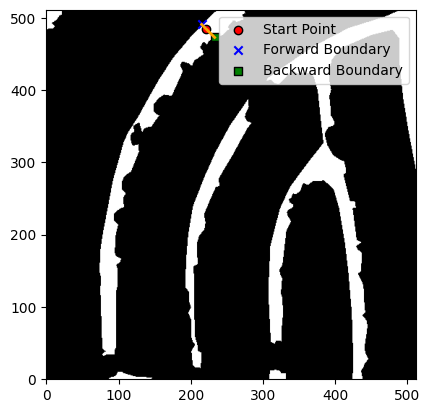

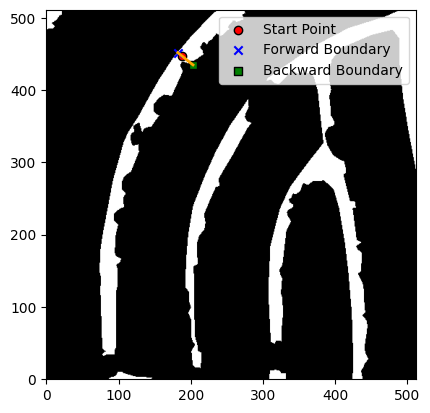

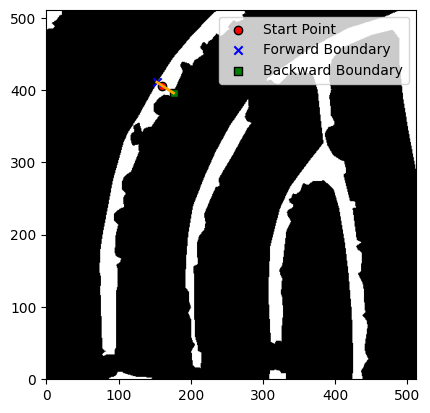

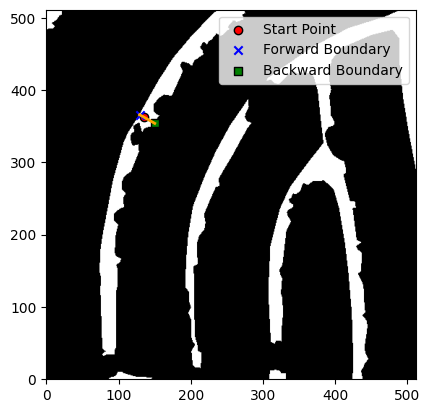

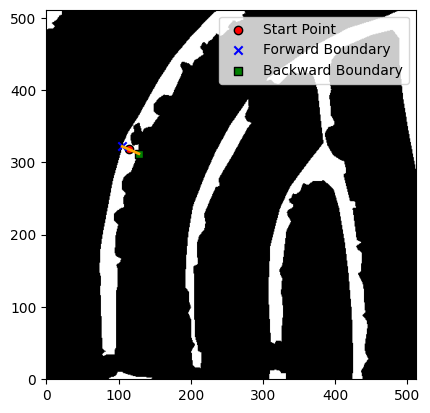

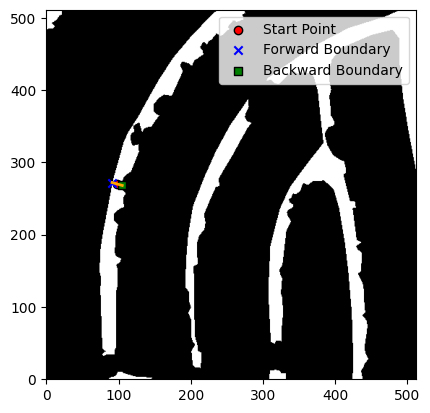

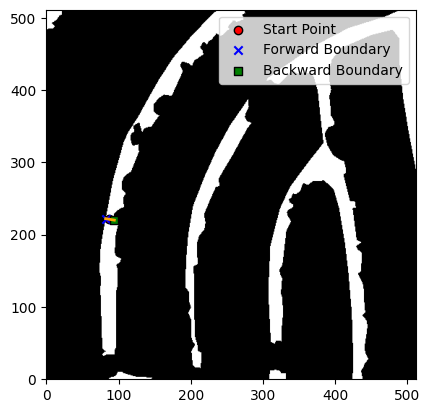

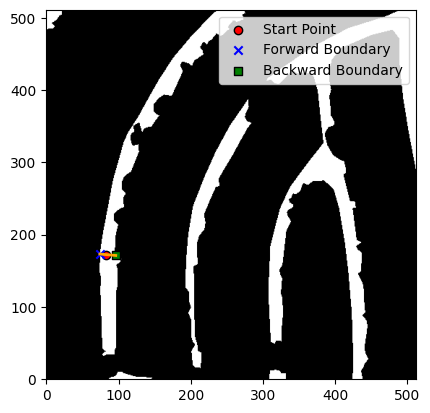

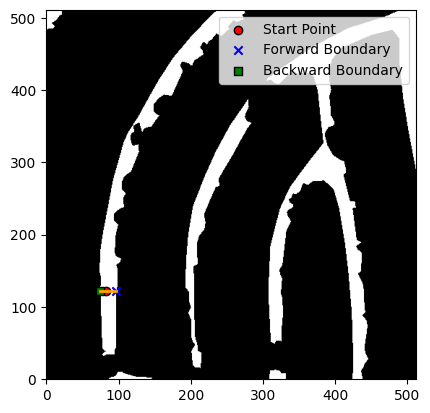

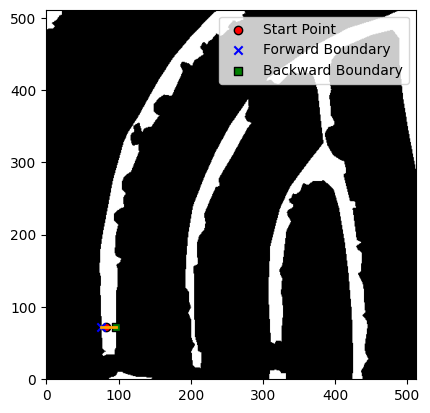

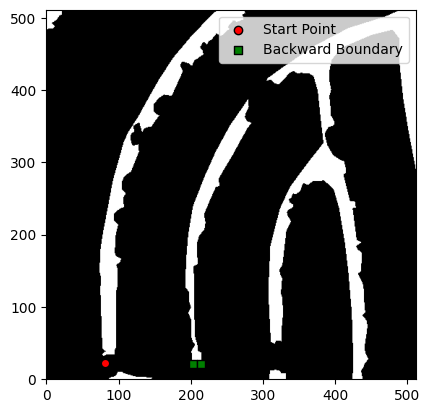

Average road width: 22.26 pixels


In [223]:
instance = scaled_patch_roads.iloc[1]
geom = instance['geometry_scaled']

if isinstance(geom, sp.MultiLineString):
    for line in geom.geoms:
        widths = measure_road_width(line, image_mask, True)
elif isinstance(geom, sp.LineString):
    widths = measure_road_width(geom, image_mask, True)

average_width = np.mean([width for _, _, width in widths])
print(f"Average road width: {average_width:.2f} pixels")

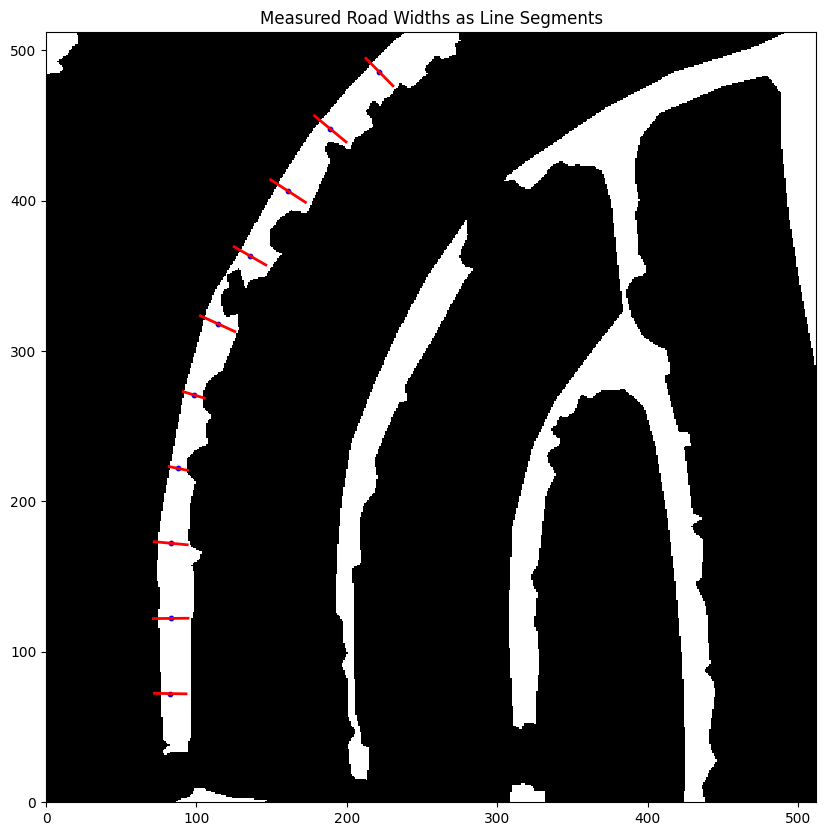

In [224]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_mask, cmap='gray', interpolation='none')

for width_info in widths:
    (point, slope), coords, width = width_info
    x0, y0 = point.x, point.y

    # Calculate dx, dy for the perpendicular line segment
    if slope == float('inf'):
        dx, dy = 0, width / 2
    elif slope == 0:
        dx, dy = width / 2, 0
    else:
        dx = (width / 2) / (1 + slope ** 2) ** 0.5
        dy = slope * dx 

    # Endpoints of the width segment
    x1, y1 = x0 - dx, y0 - dy
    x2, y2 = x0 + dx, y0 + dy

    ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)
    ax.scatter([x0], [y0], color='blue', s=10)  # Mark the center point

ax.set_xlim(0, 512)
ax.set_ylim(0, 512)
ax.set_aspect('equal')
ax.set_title("Measured Road Widths as Line Segments")
plt.show()

In [225]:
def get_patch_road_widths(roads, image_mask):
    road_widths = []
    for road in roads.itertuples():
        geom = road.geometry_scaled
        osm_id = road.osm_id
        if isinstance(geom, sp.MultiLineString):
            for line in geom.geoms:
                widths = measure_road_width(line, image_mask)
                road_widths.append((osm_id, widths))
        elif isinstance(geom, sp.LineString):
            widths = measure_road_width(geom, image_mask)
            road_widths.append((osm_id, widths))
    return road_widths

In [226]:
def get_patch_road_widths_df(roads, image_mask):
    road_widths = []
    for road in roads.itertuples():
        geom = road.geometry_scaled
        osm_id = road.osm_id
        if isinstance(geom, sp.MultiLineString):
            for line in geom.geoms:
                widths = measure_road_width(line, image_mask)
                for point_slope_pair, coords, width in widths:
                    point, slope = point_slope_pair
                    road_widths.append({
                        'osm_id': osm_id,
                        'coordinates_on_image': point,
                        'map_coordinates': coords,
                        'slope': slope,
                        'width': width
                    })
        elif isinstance(geom, sp.LineString):
            widths = measure_road_width(geom, image_mask)
            for point_slope_pair, coords, width in widths:
                point, slope = point_slope_pair
                road_widths.append({
                    'osm_id': osm_id,
                    'coordinates_on_image': point,
                    'map_coordinates': coords,
                    'slope': slope,
                    'width': width
                })
    return pd.DataFrame(road_widths)


In [227]:
patch_road_widths = get_patch_road_widths(scaled_patch_roads, image_mask)
patch_road_widths

[('48387351',
  [((<POINT (504.362 363.634)>, 0.11638263570668654),
    <POINT (121.054 14.537)>,
    13.21650698268797),
   ((<POINT (498.972 413.33)>, 0.043623358652634794),
    <POINT (121.054 14.537)>,
    20.02547884227137),
   ((<POINT (498.717 463.251)>, -0.07651846424041259),
    <POINT (121.054 14.538)>,
    23.08966987078513)]),
 ('48387353',
  [((<POINT (221.657 485.527)>, -1.0153367495279064),
    <POINT (121.053 14.538)>,
    25.517342262762643),
   ((<POINT (188.978 447.744)>, -0.8259481835406411),
    <POINT (121.053 14.538)>,
    27.121475537487534),
   ((<POINT (160.918 406.422)>, -0.6474890089645747),
    <POINT (121.053 14.537)>,
    27.478817095702123),
   ((<POINT (135.586 363.326)>, -0.5755093495087537),
    <POINT (121.053 14.537)>,
    24.276034340390392),
   ((<POINT (114.038 318.244)>, -0.4566097583049938),
    <POINT (121.053 14.537)>,
    25.082003723323943),
   ((<POINT (98.249 270.878)>, -0.30401457235359775),
    <POINT (121.053 14.537)>,
    14.674069649

In [228]:
patch_road_widths_df = get_patch_road_widths_df(scaled_patch_roads, image_mask)
patch_road_widths_df

,osm_id,coordinates_on_image,map_coordinates,slope,width
0,48387351,POINT (504.36163166110447 363.6336290931269),POINT (121.05360140917284 14.537316839027188),0.116383,13.216507
1,48387351,POINT (498.97241078402146 413.32963959357505),POINT (121.05358696606089 14.537446553379596),0.043623,20.025479
2,48387351,POINT (498.7166105160222 463.25061266071873),POINT (121.05358628051617 14.537576854919454),-0.076518,23.089670
3,48387353,POINT (221.6572761936015 485.5265866758204),POINT (121.0528437615002 14.537634998692253),-1.015337,25.517342
4,48387353,POINT (188.9779819155201 447.74400444303194),POINT (121.05275618099154 14.537536380249097),-0.825948,27.121476
5,48387353,POINT (160.9179990454084 406.4221511589769),POINT (121.05268098023744 14.537428523755487),-0.647489,27.478817
6,48387353,POINT (135.5856305858664 363.32599722523463),POINT (121.05261308948997 14.537316036059945),-0.575509,24.276034
7,48387353,POINT (114.03809025613712 318.2443143399687),POINT (121.05255534208189 14.537198365823603),-0.456610,25.082004
8,48387353,POINT (98.24854164907069 270.8776739500501),POINT (121.05251302609162 14.537074731491147),-0.304015,14.674070
9,48387353,POINT (87.94496259985888 221.9626752114085),POINT (121.05248541249978 14.53694705570147),-0.205119,12.310264


In [229]:
def generate_width_statistics(patch_road_widths_df):
    width_stats = patch_road_widths_df.groupby('osm_id')['width'].describe()
    return width_stats

In [230]:
width_statistics = generate_width_statistics(patch_road_widths_df)
width_statistics

,count,mean,std,min,25%,50%,75%,max
osm_id,,,,,,,,
48387351,3.0,18.777219,5.053558,13.216507,16.620993,20.025479,21.557574,23.089670
48387353,10.0,22.256527,5.079425,12.310264,21.278716,23.641194,25.408508,27.478817
48387355,13.0,22.361986,15.218485,5.026938,14.015868,20.323179,24.337808,67.287863
48387356,7.0,22.609105,16.056708,10.698431,16.420614,18.011646,19.145258,58.421916
48387357,11.0,25.842882,12.366816,13.061216,18.748427,20.041572,31.713259,47.024867


In [231]:
#calculate m per pixel: https://wiki.openstreetmap.org/wiki/Zoom_levels
def meters_per_pixel(lat):
    return EARTH_CIRCUFERENCE * abs(math.cos(math.radians(lat))) / (512 * (2 ** 18))

In [232]:
avg_m_per_pixel = (meters_per_pixel(min_lat) + meters_per_pixel(max_lat)) / 2
(1/avg_m_per_pixel)

3.460925935231014